<a href="https://colab.research.google.com/github/maniceet/How-do-you-like-them-Apples/blob/master/How_do_you_like_them_apples_(Model_Training).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing Packages
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import re, string, unicodedata
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from functools import reduce
from fastai.text import *
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
#Defining class to read txt file by paragraphs rather than by line
class ByParagraph:


    def __init__(self, text):
        self.text = text


    def __iter__(self):
        return self
        par = ""


    def __next__(self):
        par = []
        for line in self.text:
            if line.isspace():
                break
            par.append(line.strip())
        else:
            if not par:
                raise StopIteration()
        return ' '.join(par)


In [0]:
# Adding all paragraphs to a list for apple computers txt
apple_computers = []
with open('apple-computers.txt',"r", encoding="utf8") as f:
  for par in ByParagraph(f):
        if par == "":
            continue
        else:
            apple_computers.append(par)

In [0]:
# Adding all paragraphs to a list for apple fruit txt
apple_fruits = []
with open('apple-fruit.txt',"r", encoding="utf8") as f:
  for par in ByParagraph(f):
        if par == "":
            continue
        else:
            apple_fruits.append(par)

In [0]:
#Creating Training Data Frame
label = ['computer-company']*21 + ['fruit']*21
text = apple_computers + apple_fruits

df = pd.DataFrame(list(zip(text, label)), columns=['text', 'label'])


In [146]:
df.head()

,text,label
0,"Apple Inc. From Wikipedia, the free encycloped...",computer-company
1,"The Apple I, Apple's first product, was sold a...",computer-company
2,"Apple's ""1984"" television ad, set in a dystopi...",computer-company
3,"The first Macintosh, released in 1984 In 1984,...",computer-company
4,"The Macintosh Portable was Apple's first ""port...",computer-company


Paragraph Length: 
Mean 2456.05 words (median - 2031.500000)


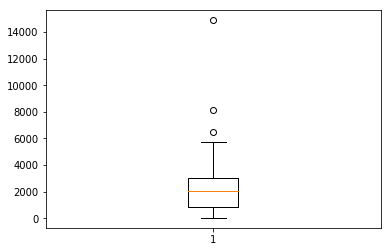

In [147]:
# Summarize Paragraph length
print("Paragraph Length: ")
result = [len(text) for text in df.text]
print("Mean %.2f words (median - %f)" % (np.mean(result), np.median(result)))
# plot review length
plt.boxplot(result)
plt.show()

In [0]:
#Cleaning Training Data

#Remove HTML Tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
r_html = lambda x: strip_html_tags(x)

#Remove accented characters

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

r_accented = lambda x: remove_accented_chars(x)

#Expand Contractions

from contraction import expand_contractions
expand = lambda x: expand_contractions(x)


#Remove special characters

def remove_special_characters(text, remove_digits=False):
    #text = text.lower()
    text = re.sub('\w*\d\w*', '', text) #Removing words that have numbers in them
    pattern = r'[^a-zA-z0-9.\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[''""_]' #Removing punctuations and underscores
    text = re.sub(pattern, '', text)
    text = re.sub(r'(.)\1+', r'\1\1', text)   #Removing characters that appear more than twice
    text = re.sub(r'\[', "",text)
    text = re.sub(r'\]', "",text)
    text = text.replace('\t', ' ')
    return text

In [0]:
functions = [strip_html_tags, remove_accented_chars, expand_contractions, remove_special_characters]

for fun in functions:
    df['text'] = df['text'].apply(fun)

In [0]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size = 0.3, stratify = df['label'])

In [151]:
train_df.head()

,text,label
12,The iPod Shuffle iPod Nano iPod Classic and i...,computer-company
9,See also Timeline of Apple products and List o...,computer-company
17,See also List of mergers and acquisitions by A...,computer-company
24,Blossoms fruits and leaves of the apple tree M...,fruit
13,The original iPhone and to scale. Main artic...,computer-company


In [152]:
valid_df.head()

,text,label
27,Brita as Iduna by Carl Larsson Germanic pagan...,fruit
28,Heracles with the apple of Hesperides Apples a...,fruit
25,Wild Malus sieversii apple in Kazakhstan The c...,fruit
26,Main article Apple symbolism,fruit
23,Botanical information,fruit


In [0]:
path = os.getcwd()

In [0]:
bs = 16
# Language model data
data_lm = TextLMDataBunch.from_df(path = os.getcwd(),train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'label')

data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [157]:
data_lm.show_batch()

idx,text
0,with xxmaj nike to xxunk the xxunk xxmaj sports xxmaj kit xxunk xxunk to xxunk and monitor their runs with itunes and the xxmaj nike website . xxmaj apple currently sells four variants of the ipod ipod xxmaj shuffle xxmaj xxunk digital audio player currently available in a xxup gb model introduced in . ipod xxmaj nano xxmaj portable media player currently available in a xxup gb model introduced in
1,generally used for making juice and have little fresh market value . xxmaj the skin of xxunk apples is generally red yellow green or pink although many xxunk or xxunk varieties may be found . xxmaj the skin may also be xxunk or xxunk russeted xxunk xxunk and brown . xxmaj the skin is xxunk in a xxunk layer of xxunk xxunk xxmaj the flesh is generally xxunk xxunk though
2,the stainless steel band around the edge of the device which also xxunk as the phones cellular signal and wifi antenna . xxmaj the issue was xxunk by a xxmaj bumper xxmaj case xxunk by xxmaj apple for free to all owners for a few months . xxmaj in xxmaj june xxmaj apple xxunk xxmaj nokia to become the worlds biggest smartphone maker by xxunk . xxmaj on xxmaj october
3,from the xxmaj apple xxup tv . xxmaj in xxmaj september xxmaj apple discontinued the original xxup gb xxmaj apple xxup tv and now xxunk to produce and sell the xxup gb xxmaj apple xxup tv . xxmaj on xxmaj september alongside the release of the new line of ipod devices for the year xxmaj apple released a xxunk xxunk xxmaj apple xxup tv . xxmaj the new device is
4,xxmaj it has been xxunk that the combination of these three products was responsible for the xxunk of the desktop publishing market . xxmaj the xxmaj mac was xxunk powerful in the desktop publishing market due to its advanced graphics capabilities which had xxunk been xxunk in to create the xxunk xxmaj macintosh xxup gui . xxmaj in a power xxunk developed between xxmaj jobs and xxup ceo xxmaj john


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [160]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


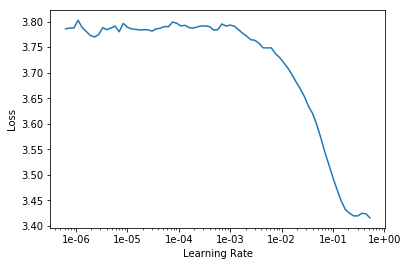

In [161]:
learn.recorder.plot(skip_end=15)

In [162]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.705788,3.050062,0.362372,00:00


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [166]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.218893,2.935408,0.377041,00:01
1,2.910015,3.470449,0.303699,00:01
2,2.626214,3.747241,0.257015,00:01
3,2.278730,3.755704,0.291709,00:01
4,1.843900,3.982887,0.282908,00:01
5,1.448126,4.032377,0.282015,00:01
6,1.124884,3.955369,0.290816,00:01
7,0.873121,3.866679,0.302551,00:01
8,0.684437,3.875694,0.298342,00:01
9,0.543109,3.881415,0.299872,00:01


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "Steve jobs was "
N_WORDS = 40
N_SENTENCES = 2

In [170]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Steve jobs was  aired in the United States List of New Macbook Pro Apples first laptop with an Intel announced in February . At the Worldwide Developers Conference keynote meeting
Steve jobs was  present in January Steve Jobs introduced the iphone in a board and the Apple Lisa in with other countries set to sell the Apple i personal computer kit a computer single xxbos The


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = os.getcwd(), train_df = train_df, valid_df = valid_df, text_cols= 'text', label_cols= 'label', bs=16)

In [173]:
data_clas.save('data_clas.pkl')
data_clas = load_data(path, 'data_clas.pkl', bs=bs)
data_clas.show_batch()

text,target
xxbos xxmaj apple store in xxmaj xxunk xxmaj new xxmaj york xxmaj on xxmaj january xxmaj jobs announced in an internal xxmaj apple memo that he would take another xxunk leave of absence for an xxunk period to allow him to focus on his health . xxmaj xxunk operating xxunk xxmaj tim xxmaj cook xxunk xxmaj jobs xxunk operations at xxmaj apple although xxmaj jobs would still xxunk xxunk in,computer-company
xxbos xxmaj the macbook xxmaj pro xxmaj apples first laptop with an xxmaj intel xxunk announced in xxmaj january . xxmaj at the xxmaj worldwide xxmaj developers xxmaj conference keynote xxunk on xxmaj june xxmaj steve xxmaj jobs announced that xxmaj apple would xxunk producing xxmaj xxunk xxmaj mac computers in . xxmaj on xxmaj january the new macbook xxmaj pro and imac became the first xxmaj apple computers to,computer-company
xxbos xxmaj the original iphone and to scale . xxmaj main article iphone xxmaj at the xxmaj macworld xxmaj conference xxmaj expo in xxmaj january xxmaj steve xxmaj jobs introduced the xxunk iphone a xxunk of an xxmaj xxunk smartphone and ipod . xxmaj the original iphone was released on xxmaj june for xxup gb and xxup gb with an xxup att contract . xxmaj on xxmaj february it was,computer-company
xxbos xxmaj the current generation xxmaj apple xxup tv . xxmaj at the xxmaj macworld conference xxmaj jobs xxunk the xxmaj apple xxup tv xxunk known as the xxunk a xxunk video device xxunk to xxunk the sale of content from itunes with xxunk xxunk . xxmaj the device xxunk up to a users xxup tv and xxunk either xxunk wifi or a xxunk network with one computers itunes library,computer-company
xxbos xxmaj apple xxmaj inc. xxmaj from xxmaj xxunk the free xxunk xxmaj this article is about the technology company . xxmaj for other companies named xxmaj apple see xxmaj apple disambiguation . xxmaj page xxunk xxmaj xxunk . . xxmaj apple xxmaj inc. xxmaj apple logo xxunk xxmaj logo used since xxmaj type xxmaj public xxmaj traded as xxup nasdaq xxup xxunk xxup nasdaq component xxup xxunk component xxmaj,computer-company


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [175]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


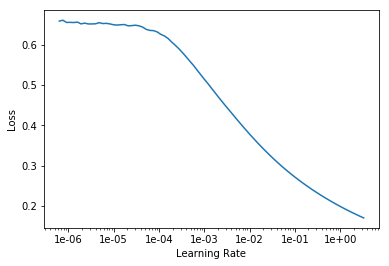

In [176]:
learn.recorder.plot()

In [177]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.721263,0.690006,0.461538,00:01


In [0]:
learn.save('first')


In [0]:
learn.load('first');

In [182]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.554242,0.686590,0.461538,00:02


In [0]:
learn.save('second')


In [0]:
learn.load('second');

In [190]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.411914,0.685110,0.461538,00:02


In [0]:
learn.save('third')


In [0]:
learn.load('third');

In [209]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.421289,0.667146,0.615385,00:02
1,0.304515,0.320154,0.923077,00:02
2,0.207521,0.217764,0.923077,00:02
3,0.155252,0.264643,0.923077,00:02


In [0]:
learn.save('fine_tuned_classifier')

In [211]:
learn.predict("When Steve Jobs stepped down as Apple's CEO in August 2011, people said it was the end of an era. The departure of Apple design chief Jony Ive, announced Thursday, is the latest sign of the new Apple. \
For the past couple of decades, Apple has gone through one of the most dramatic resurgences in history. Its tale of dramatic rise under co-founder Jobs, its decline and near death after his ouster, and then its rebirth are the stuff of Silicon Valley legend")

(Category computer-company, tensor(0), tensor([0.9403, 0.0597]))

In [212]:
learn.predict('ve and Jobs were close friends, bonding over frequent lunches and a similar sensibility for design. "We on the first meeting, in a quite shocking way, really did click," Ive said in a rare interview in 2017. "We just established an immediate understanding."')

(Category computer-company, tensor(0), tensor([0.8515, 0.1485]))

In [213]:
learn.predict('The departure of Ive, whose soft, British voice introduced Apple hardware in countless sizzle reels, is the latest sign of major shifts within Apple. The company grew to become one of the worlds most profitable and highly valued companies, worth nearly $1 trillion, on the back of the iPhone.')

(Category computer-company, tensor(0), tensor([0.8643, 0.1357]))

In [214]:
learn.predict('The gardens of Kashmir have the best Apples grown all over the world')

(Category computer-company, tensor(0), tensor([0.7245, 0.2755]))

In [215]:
learn.predict('The gardens of Kashmir have the best Apples grown all over the world')[0]

Category computer-company

In [216]:
learn.data.batch_size

16

In [0]:
test_df = df
learn.data.add_test(test_df['label'])
prob_preds = learn.get_preds(ds_type=DatasetType.Test, ordered=True)

In [218]:
prob_preds[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])